# Loading python libraries
#### Python is developed under an OSI-approved open source license, making it freely usable and distributable, even for commercial use.

In [316]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import os
import glob
from sklearn import preprocessing
from pysptools import spectro as sp
from pysptools import distance
from IPython.display import display
import ipywidgets as widgets
from math import*
from ipywidgets import IntProgress
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
from sklearn.metrics import auc

# Loading Functions

* Widegets
    * on_value_change_min - this function monitors the change in value of the slider
    * on_value_change_max - this function monitors the change in value of the slider
* FolderAndFileProcessing
    * ReadFilePaths - This function takes input as source folder and file extension and returns the path of all the files inside the folder with the supplied extension
    * ReadFile - This functions purpose is to read individual file, it takes file path, rows to skip while reading the file and type of seperation as input
    * GetValuesFromFile - This function uses ReadFile read a file and then filters out desired column
    * WriteDictToExcel - This function is used to write the output of the analysis to excel file
    * combine_dicts - This function is used to combine two dictionaries in python into one dictionary
* SpectraComparision(all functions normalizes and removes continum after subsetting the spectral signals)
    * SFF - This function takes reference spectra and user input spectrum as input and process the signals using root mean squared algorithm and generates the score table with most probable mineral having the least score
    * SAM - This function takes reference spectra and user input spectrum as input and process the signals using root mean squared algorithm and generates the score table with most probable mineral having the least score
    * SFF_CrossCorrelation - This function takes reference spectra and user input spectrum as input and process the signals using cross-correlation algorithm and generates the score table with most probable mineral having the highest score(closer to 1) and least probable mineral having the lowest score(closer to -1)
    * SpectralInformationDivergence - Computes the spectral information divergence between two vectors.

In [317]:
### https://dataaspirant.com/five-most-popular-similarity-measures-implementation-in-python/
### https://towardsdatascience.com/four-ways-to-quantify-synchrony-between-time-series-data-b99136c4a9c9
        
class FolderAndFileProcessing:
    def ReadFilePaths(source, ext):
        return glob.glob(source + "/**/*." + ext, recursive = True)
    
    def ReadFile(file, rowToSkip, seperation):
        return pd.read_csv(file ,skiprows = rowToSkip, sep = seperation) 
    
    def GetValuesFromFile(file, rowToSkip, seperation, column):
        fileData = FolderAndFileProcessing.ReadFile(file , rowToSkip, seperation)
        return fileData[column]
    
    def WriteDictToExcel(targetPath, filename, dictionary):
        df = pd.DataFrame.from_dict(dictionary)
        os.makedirs(targetPath, exist_ok=True)
        df.to_excel(targetPath+filename)
    
    def combine_dicts(a, b):
        for key in b:
            if key in a:
                if b[key] <  a[key]:
                    b[key] = a[key]
                #b[key] = b[key] + a[key]
        c = {**a, **b}
        return c
        
class SpectraComparision:
    
    
    
    def SFF_SAM(fileList, spectraValue, fileListContinumRemoval, waveLength, minIndex, maxIndex, fileListNonContinumRemoval):
        mineralScore = {}
        normalized_spectraValue = preprocessing.normalize([spectraValue[minIndex:maxIndex]])[0]
        try:
            continumRemoved_spectraValue = sp.convex_hull_removal(normalized_spectraValue, waveLength[minIndex:maxIndex])[0]
        except:
            return mineralScore
        for index in range(len(fileList)):
            continumRemoved_idealReflectance = fileListContinumRemoval[index]
            nonContinumRemoved_idealReflectance = fileListNonContinumRemoval[index]
            
            scoreSam = distance.SAM(normalized_spectraValue, nonContinumRemoved_idealReflectance)
            scoreSam = 1 - scoreSam
            scoreSFF = distance.NormXCorr(np.array(continumRemoved_spectraValue), np.array(continumRemoved_idealReflectance))
            score = scoreSFF + scoreSam
            mineralScore[fileList[index].split('/')[-1].replace('_AREF.txt','').replace('.txt','').replace('s07_ASD_','')] = score
        mineralScore = sorted(mineralScore.items(), key=lambda x: x[1], reverse=True)
        return mineralScore
    
    def SFF_SAM_BE(fileList, spectraValue, fileListContinumRemoval, waveLength, minIndex, maxIndex, fileListNonContinumRemoval):
        mineralScore = {}
        normalized_spectraValue = preprocessing.normalize([spectraValue[minIndex:maxIndex]])[0]
        
        normalized_spectraValueBE = np.array(preprocessing.normalize([spectraValue[minIndex:maxIndex]])[0])
        normalized_spectraValueBE = normalized_spectraValueBE - normalized_spectraValueBE.mean()
        normalized_spectraValueBE = 1*(normalized_spectraValueBE >= 0)
        
        try:
            continumRemoved_spectraValue = sp.convex_hull_removal(normalized_spectraValue, waveLength[minIndex:maxIndex])[0]
        except:
            return mineralScore
        for index in range(len(fileList)):
            continumRemoved_idealReflectance = fileListContinumRemoval[index]
            nonContinumRemoved_idealReflectance = fileListNonContinumRemoval[index]
            
            scoreSam = distance.SAM(normalized_spectraValue, nonContinumRemoved_idealReflectance)
            scoreSam = 1 - scoreSam
            scoreSFF = distance.NormXCorr(np.array(continumRemoved_spectraValue), np.array(continumRemoved_idealReflectance))
            
            noncontinumRemoved_idealReflectanceBE = np.array(fileListNonContinumRemoval[index])
            noncontinumRemoved_idealReflectanceBE = noncontinumRemoved_idealReflectanceBE - noncontinumRemoved_idealReflectanceBE.mean()
            noncontinumRemoved_idealReflectanceBE = 1*(noncontinumRemoved_idealReflectanceBE >= 0)
            
            scoreBE = 1*(normalized_spectraValueBE != noncontinumRemoved_idealReflectanceBE)
            scoreBE = scoreBE.mean()
            scoreBE = 1 - scoreBE
            
            
            score = scoreSFF + scoreSam + scoreBE
            mineralScore[fileList[index].split('/')[-1].replace('_AREF.txt','').replace('.txt','').replace('s07_ASD_','')] = score
        mineralScore = sorted(mineralScore.items(), key=lambda x: x[1], reverse=True)
        return mineralScore
    
    def CombinedAlgorithmsResult(fileList, spectraValue, fileListContinumRemoval, waveLength, minIndex, maxIndex, fileListNonContinumRemoval):
        mineralScore = {}
        normalized_spectraValue = preprocessing.normalize([spectraValue[minIndex:maxIndex]])[0]
        try:
            continumRemoved_spectraValue = sp.convex_hull_removal(normalized_spectraValue, waveLength[minIndex:maxIndex])[0]
        except:
            return mineralScore
        for index in range(len(fileList)):
            continumRemoved_idealReflectance = fileListContinumRemoval[index]
            nonContinumRemoved_idealReflectance = fileListNonContinumRemoval[index]
            
            scoreSam = distance.SAM(normalized_spectraValue, nonContinumRemoved_idealReflectance)
            scoreSam = 1 - scoreSam
            
            scoreSFF = distance.NormXCorr(np.array(continumRemoved_spectraValue), np.array(continumRemoved_idealReflectance))
            
            
            scoreSID = distance.SID(normalized_spectraValue, nonContinumRemoved_idealReflectance)
            scoreSID = 1 - scoreSID
            
            
            score = scoreSFF + scoreSam + scoreSID
            
            
            mineralScore[fileList[index].split('/')[-1].replace('_AREF.txt','').replace('.txt','').replace('s07_ASD_','')] = score
        mineralScore = sorted(mineralScore.items(), key=lambda x: x[1], reverse=True)
        return mineralScore
    
    def BinaryEncoding(fileList, spectraValue, fileListContinumRemoval, waveLength, minIndex, maxIndex):
        
        mineralScore = {}
        normalized_spectraValue = np.array(preprocessing.normalize([spectraValue[minIndex:maxIndex]])[0])
        normalized_spectraValue = normalized_spectraValue - normalized_spectraValue.mean()
        normalized_spectraValue = 1*(normalized_spectraValue >= 0)

        for index in range(len(fileList)):
            continumRemoved_idealReflectance = np.array(fileListContinumRemoval[index])
            continumRemoved_idealReflectance = continumRemoved_idealReflectance - continumRemoved_idealReflectance.mean()
            continumRemoved_idealReflectance = 1*(continumRemoved_idealReflectance >= 0)
            
            score = 1*(normalized_spectraValue != continumRemoved_idealReflectance)
            score = score.mean()
            score = 1 - score
            mineralScore[fileList[index].split('/')[-1].replace('_AREF.txt','').replace('.txt','').replace('s07_ASD_','')] = score
        mineralScore = sorted(mineralScore.items(), key=lambda x: x[1], reverse=True)
        return mineralScore
    
    def SFF(fileList, spectraValue, fileListContinumRemoval, waveLength, minIndex, maxIndex):
        mineralScore = {}
        normalized_spectraValue = preprocessing.normalize([spectraValue[minIndex:maxIndex]])[0]
        try:
            continumRemoved_spectraValue = sp.convex_hull_removal(normalized_spectraValue, waveLength[minIndex:maxIndex])[0]
        except:
            return mineralScore
        for index in range(len(fileList)):
            continumRemoved_idealReflectance = fileListContinumRemoval[index]
            score = distance.NormXCorr(np.array(continumRemoved_spectraValue), np.array(continumRemoved_idealReflectance))
            mineralScore[fileList[index].split('/')[-1].replace('_AREF.txt','').replace('.txt','').replace('s07_ASD_','')] = score
        mineralScore = sorted(mineralScore.items(), key=lambda x: x[1], reverse=True)
        return mineralScore
    
    def SAM(fileList, spectraValue, fileListContinumRemoval, waveLength, minIndex, maxIndex):
        mineralScore = {}
        normalized_spectraValue = preprocessing.normalize([spectraValue[minIndex:maxIndex]])[0]

        for index in range(len(fileList)):
            continumRemoved_idealReflectance = fileListContinumRemoval[index]
            score = distance.SAM(normalized_spectraValue, continumRemoved_idealReflectance)
            score = 1 - score
            mineralScore[fileList[index].split('/')[-1].replace('_AREF.txt','').replace('.txt','').replace('s07_ASD_','')] = score
        mineralScore = sorted(mineralScore.items(), key=lambda x: x[1], reverse=True)
        return mineralScore

    def chebyshev(fileList, spectraValue, fileListContinumRemoval, waveLength, minIndex, maxIndex):
        mineralScore = {}
        normalized_spectraValue = preprocessing.normalize([spectraValue[minIndex:maxIndex]])[0]
        
        for index in range(len(fileList)):
            continumRemoved_idealReflectance = fileListContinumRemoval[index]
            score = distance.chebyshev(np.array(normalized_spectraValue), np.array(continumRemoved_idealReflectance))
            score = 1 - score
            mineralScore[fileList[index].split('/')[-1].replace('_AREF.txt','').replace('.txt','').replace('s07_ASD_','')] = score
        mineralScore = sorted(mineralScore.items(), key=lambda x: x[1])
        return mineralScore

    def SpectralInformationDivergence(fileList, spectraValue, fileListContinumRemoval, waveLength, minIndex, maxIndex):
        mineralScore = {}
        normalized_spectraValue = preprocessing.normalize([spectraValue[minIndex:maxIndex]])[0]

        for index in range(len(fileList)):
            continumRemoved_idealReflectance = fileListContinumRemoval[index]
            score = distance.SID(normalized_spectraValue, continumRemoved_idealReflectance)
            score = 1 - score
            mineralScore[fileList[index].split('/')[-1].replace('_AREF.txt','').replace('.txt','').replace('s07_ASD_','')] = score
        mineralScore = sorted(mineralScore.items(), key=lambda x: x[1], reverse=True)
        return mineralScore
    
    def square_rooted(x):
        return round(sqrt(sum([a*a for a in x])),3)
 
    def cosine_similarity(x,y):
        numerator = sum(a*b for a,b in zip(x,y))
        denominator = SpectraComparision.square_rooted(x)* SpectraComparision.square_rooted(y)
        #return round(numerator/float(denominator),3)
        return numerator/float(denominator)
    

### Algorithm Analysis defination

In [539]:
class algoAnalysis:
    def FScore(n, dictionaryList, fileNameList):
        #n = 50
        f1ScoreMeanlist = []
        results = pd.DataFrame(columns=['n', 'index', 'fScore'])
        for i in range(n):
            #print(i)
            #ignoreList = ["AlCU91", "AlCU98-8H" ]
            fscoreList = []
            precisionResult=[]
            recallResult=[]
            tmp_results = pd.DataFrame()


            for outerIndex in range(len(dictionaryList)):
                TruePositive = 0
                FalsePositive = 0
                FalseNegative = 0

                Precision = 0
                Recall = 0
                F1Score = 0

                tempDictionary = dictionaryList[outerIndex]
                fileNamesTemp = fileNameList[outerIndex].replace('.xlsx','').split('_')[1:]
                falseList = dict.fromkeys(set(fileNamesTemp), True)
                for innerIndex in range(len(tempDictionary)):
                    tempBoolState = False
                    mineralNameTemp = tempDictionary[innerIndex][0].split(' ')[0]
                    for fileName in fileNamesTemp:
                        if mineralNameTemp in fileName:
                            #print(fileName)
                            falseList[mineralNameTemp] = False
                            TruePositive = TruePositive + 1
                            tempBoolState = True
                    if tempBoolState == False:
                        FalsePositive = FalsePositive + 1
                    if (innerIndex + 1 == i+1):
                        FalseNegative = sum(falseList.values())
                        Precision = TruePositive / (TruePositive + FalsePositive)
                        Recall = TruePositive / (TruePositive + FalseNegative)
                        if Precision != 0 or Recall != 0:
                            F1Score = 2 * (Precision * Recall) / (Precision + Recall)
                        else:
                            F1Score = 0
                        precisionResult.append(Precision)
                        recallResult.append(Recall)
                        fscoreList.append(F1Score)
                        break
            tmp_results['n'] = [i+1]*len(fscoreList)
            tmp_results['index'] = range(len(fscoreList))
            tmp_results['fScore'] = fscoreList
            tmp_results['recall'] = recallResult
            tmp_results['precision'] = precisionResult
            results = results.append(tmp_results)
        return results

    def AUCScore(n, dictionaryList, fileNameList):
        f1ScoreMeanlist = []
        resultsAUC = pd.DataFrame(columns=['index', 'AUCScore'])

        steps = 1/n
        AUCScore = []
        X = [0]
        Y = [0]



        for outerIndex in range(len(dictionaryList)):
            X = [0]
            Y = [0]
            tempDictionary = dictionaryList[outerIndex]
            fileNamesTemp = fileNameList[outerIndex].replace('.xlsx','').split('_')[1:]
            falseList = dict.fromkeys(set(fileNamesTemp), True)
            for innerIndex in range(len(tempDictionary)):
                tempBoolState = False
                mineralNameTemp = tempDictionary[innerIndex][0].split(' ')[0]
                for fileName in fileNamesTemp:
                    if mineralNameTemp in fileName:
                        tempBoolState = True
                        Y.append(Y[-1] + steps)
                        X.append(X[-1])

                if tempBoolState == False:
                    Y.append(Y[-1])
                    X.append(X[-1] + steps)
                if (innerIndex + 1 == n):
                    X = np.array(X)/np.max(X)
                    Y = np.array(Y)/np.max(Y)
                    AUCScore.append(auc(X,Y))
                    break
        resultsAUC['index'] = range(len(AUCScore))
        resultsAUC['AUCScore'] = AUCScore
        return resultsAUC

In [418]:
def ROC(scores, matches, rev=True):
    values = sorted(zip(scores, matches), reverse=rev, key=lambda x: x[0])
    tpr, fpr = [0], [0]
    for score, match in values:
        if match:
            tpr.append(tpr[-1]+1)
            fpr.append(fpr[-1])
        else:
            tpr.append(tpr[-1])
            fpr.append(fpr[-1]+1)
    tpr = np.array(tpr)/np.max(tpr)
    fpr = np.array(fpr)/np.max(fpr)
    AUC = auc(fpr, tpr)
    return tpr, fpr, AUC

### Variable Declarations

In [318]:
##txt file declarations
#txtPath = "../data/enviData/cleanFolder/"
txtPath = "../data/enviData/ENVIFilesUsgsProcessed/"
extensionTxt= 'txt'
indidualplotlimit = 20


###sed file declarations
#sedPath = "../data/vulcano/16062019/astrobay/Astrobay spot 2/"
#sedPath = "../data/vulcano/16062019/volcanello/spot13/"
sedPath = "../data/enviData/algorithmPredictionDataProcessed/"
extensionSed= 'txt'

minWavelength = []
maxWavelength = []

minIndex = []
maxIndex = []

algorithmList = ['SFF', 'SFF_SAM', 'SFF_SAM_BE', 'SAM', 'BE', 'SID', 'Chebyshev']


#numberOfFeatureToAnalyze = int(input("Enter the totlal number of features you want to anaylze: "))

# Select the wavelength range
### Select the range to subset the data

In [319]:
numberOfFeatureToAnalyze = 5

minWavelength = [400, 700, 1300, 1600, 2000]
maxWavelength = [750, 1400, 1700, 2100, 2500]

In [320]:
minIndex = []
maxIndex = []


for ind in range(numberOfFeatureToAnalyze):
    minIndex.append(minWavelength[ind] - 350)
    maxIndex.append(maxWavelength[ind] - 350 + 1)

In [321]:
maxIndex[0]

401

# Populating paths
### Getting the paths to both reference spectrum and user input spectrum

In [322]:
txt_files = FolderAndFileProcessing.ReadFilePaths(txtPath,extensionTxt)
sed_files = FolderAndFileProcessing.ReadFilePaths(sedPath,extensionSed)

# Defining wavelength range

In [323]:
waveLength = list(range(350,2501))

# Continium removal after splicing the data
### Splice the ideal spectral data and remove the continium

In [324]:
max_count = len(txt_files)
for ind in range(numberOfFeatureToAnalyze):
    minIndexTemp = minIndex[ind]
    maxIndexTemp = maxIndex[ind]
    globals()['fileListContinumRemoval_'+str(ind)] = []
    globals()['fileListNonContinumRemoval_'+str(ind)] = []
    globals()['progreesBar'+str(ind)] = IntProgress(min=0, max=max_count) # instantiate the bar
    display(globals()['progreesBar'+str(ind)]) # display the bar

    for index in range(len(txt_files)):
        idealReflectance = FolderAndFileProcessing.GetValuesFromFile(txt_files[index], 0, ' ','reflectance')
        normalized_idealReflectance = preprocessing.normalize([idealReflectance[minIndexTemp:maxIndexTemp]])[0]
        continumRemoved_idealReflectance = sp.convex_hull_removal(normalized_idealReflectance, waveLength[minIndexTemp:maxIndexTemp])[0]
        globals()['fileListContinumRemoval_'+str(ind)].append(continumRemoved_idealReflectance)
        globals()['fileListNonContinumRemoval_'+str(ind)].append(normalized_idealReflectance)
        
        globals()['progreesBar'+str(ind)].style = {'description_width': 'initial'}
        globals()['progreesBar'+str(ind)].description = 'Loading ideal files feature '+ str(ind + 1) + ': ' + str(index + 1) + '/' + str(max_count)
        globals()['progreesBar'+str(ind)].value += 1 # signal to increment the progress bar
        
        

IntProgress(value=0, max=480)

IntProgress(value=0, max=480)

IntProgress(value=0, max=480)

IntProgress(value=0, max=480)

IntProgress(value=0, max=480)

### Remove the continium from the entire wavelegth of ideal spectral data 

# Analysis
### Taking user data as input and writing the result in similar type of folder structure with weighted output for each input data stored with similar name in an excel file and graph plots stored as png

In [326]:
#dictionaryList = []
#fileNameList = []
max_countSed = len(sed_files)
targetFolderToReplace = '/data/enviData'
algorithmRunFunction = 'SpectraComparision.' + algorithmType
minWav = '400'
maxWav = '2500'
areaName = 'mineral testing'

for algorithmType in algorithmList:
    globals()['dictionaryList_'+str(algorithmType)] = []
    globals()['fileNameList_'+str(algorithmType)] = []

    globals()['progreesBar'+str(algorithmType)] = IntProgress(min=0, max=max_countSed) # instantiate the bar
    display(globals()['progreesBar'+str(algorithmType)])

    #progreesBarSed = IntProgress(min=0, max=max_countSed) 
    #display(progreesBarSed)

    #algorithmType = 'SFF_SAM_BE'


    targetFolderNewName = '/' + algorithmType + '_' + minWav + '_' + maxWav + '_' + str(indidualplotlimit) + 'Top'

    for index in range(len(sed_files)):  
        totalDict = {}
        targetfilename = sed_files[index].replace(targetFolderToReplace, targetFolderNewName).split('/')[-1].replace('.txt','.xlsx')
        list_string = sed_files[index].replace(targetFolderToReplace, targetFolderNewName).split('/')[0:-1]
        targetPath = '/'.join(list_string) + '/'
        testData = FolderAndFileProcessing.GetValuesFromFile(sed_files[index],  0, ' ','reflectance')
        minIndexTemp = 0
        maxIndexTemp = 0
        for indexRange in range(numberOfFeatureToAnalyze):
            minIndexTemp = minIndex[indexRange]
            maxIndexTemp = maxIndex[indexRange]
            if algorithmType == 'SFF' or algorithmType == 'NormXCorr' or algorithmType == 'SFF_CrossCorrelation' or algorithmType == 'SFF_SAM' or algorithmType == 'SFF_SAM_BE' or algorithmType == 'CombinedAlgorithmsResult' or algorithmType == 'RMS':
                fileListSelected = globals()['fileListContinumRemoval_'+str(indexRange)]
                fileListSelectedNonContinumRemoval = globals()['fileListNonContinumRemoval_'+str(indexRange)]
            else:
                fileListSelected = globals()['fileListNonContinumRemoval_'+str(indexRange)]

            if algorithmType == 'SFF_SAM_BE':
                dictMineralValue = SpectraComparision.SFF_SAM_BE(txt_files, testData, fileListSelected, waveLength, minIndexTemp, maxIndexTemp, fileListSelectedNonContinumRemoval)
            if algorithmType == 'SFF_SAM':
                dictMineralValue = SpectraComparision.SFF_SAM(txt_files, testData, fileListSelected, waveLength, minIndexTemp, maxIndexTemp, fileListSelectedNonContinumRemoval)
            if algorithmType == 'SAM':
                dictMineralValue = SpectraComparision.SAM(txt_files, testData, fileListSelected, waveLength, minIndexTemp, maxIndexTemp)
            if algorithmType == 'SFF':
                dictMineralValue = SpectraComparision.SFF(txt_files, testData, fileListSelected, waveLength, minIndexTemp, maxIndexTemp)
            if algorithmType == 'SID':
                dictMineralValue = SpectraComparision.SpectralInformationDivergence(txt_files, testData, fileListSelected, waveLength, minIndexTemp, maxIndexTemp)
            if algorithmType == 'Chebyshev':
                dictMineralValue = SpectraComparision.chebyshev(txt_files, testData, fileListSelected, waveLength, minIndexTemp, maxIndexTemp)
            if algorithmType == 'BE':
                dictMineralValue = SpectraComparision.BinaryEncoding(txt_files, testData, fileListSelected, waveLength, minIndexTemp, maxIndexTemp)

            if len(totalDict) == 0:
                totalDict = dict(dictMineralValue)
            else:
                tempDict = dict(dictMineralValue)
                totalDict = FolderAndFileProcessing.combine_dicts(totalDict, tempDict)

        totalDict = sorted(totalDict.items(), key=lambda x: x[1], reverse=True)

        globals()['dictionaryList_'+str(algorithmType)].append(totalDict)
        globals()['fileNameList_'+str(algorithmType)].append(targetfilename)
        #dictionaryList.append(totalDict)
        #fileNameList.append(targetfilename)

        #FolderAndFileProcessing.WriteDictToExcel(targetPath, targetfilename, totalDict)


        #progreesBarSed.style = {'description_width': 'initial'}
        #progreesBarSed.description = 'Processing files ' + str(index + 1)
        #progreesBarSed.value += 1 # signal to increment the progress bar

        globals()['progreesBar'+str(algorithmType)].style = {'description_width': 'initial'}
        globals()['progreesBar'+str(algorithmType)].description = 'Processing files ('+ str(algorithmType) + ') ' + str(index + 1)
        globals()['progreesBar'+str(algorithmType)].value += 1 # signal to increment the progress bar


IntProgress(value=0, max=150)

IntProgress(value=0, max=150)

IntProgress(value=0, max=150)

IntProgress(value=0, max=150)

IntProgress(value=0, max=150)

IntProgress(value=0, max=150)

IntProgress(value=0, max=150)

### FSCore

In [515]:
for algorithmType in algorithmList:
    dictList = globals()['dictionaryList_'+str(algorithmType)]
    fileNameList = globals()['fileNameList_'+str(algorithmType)]
    #globals()['DataFrame_'+str(algorithmType)] = []
    globals()['DataFrame_'+str(algorithmType)] = algoAnalysis.FScore(50, dictList, fileNameList)

<AxesSubplot:xlabel='n', ylabel='fScore'>

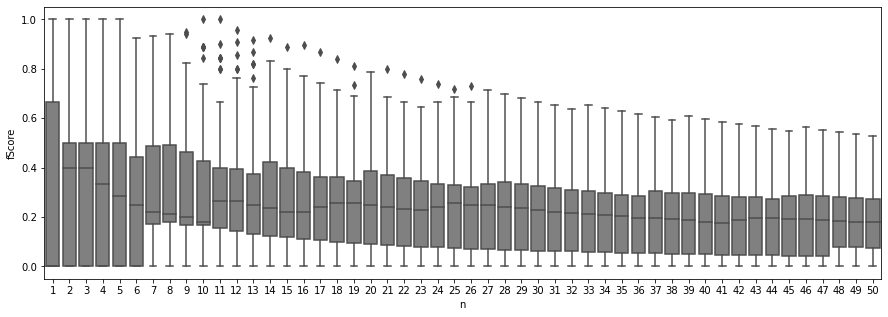

In [522]:
fig = plt.figure(figsize=(15, 5))
sns.boxplot(data=DataFrame_SFF_SAM_BE, x='n', y='fScore', color='gray')

### AUC 

In [550]:
aucDataFrame = pd.DataFrame(columns=['algorithm', 'AUCScore'])
for algorithmType in algorithmList:
    tmp_results = pd.DataFrame()
    dictList = globals()['dictionaryList_'+str(algorithmType)]
    fileNameList = globals()['fileNameList_'+str(algorithmType)]
    tempDataFrame = algoAnalysis.AUCScore(20, dictList, fileNameList)
    tmp_results['algorithm'] = [algorithmType] * len(AUCScore)
    tmp_results['AUCScore'] = tempDataFrame['AUCScore']
    aucDataFrame = aucDataFrame.append(tmp_results)

/var/folders/2n/8qtpk81d3fs76p8xpr2dw1qm0000gr/T/ipykernel_38922/3259995386.py:89: RuntimeWarning: invalid value encountered in true_divide
  Y = np.array(Y)/np.max(Y)


<AxesSubplot:xlabel='algorithm', ylabel='AUCScore'>

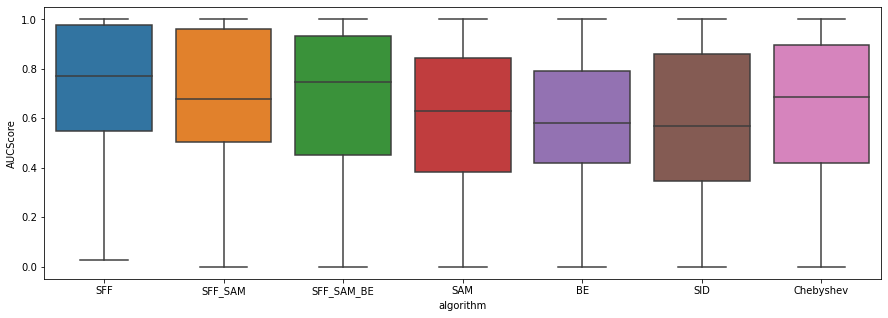

In [554]:
fig = plt.figure(figsize=(15, 5))
sns.boxplot(data=aucDataFrame, x='algorithm', y='AUCScore')


### Accuracy Report

In [ ]:
progreesBarSed = IntProgress(min=0, max=max_countSed) 
display(progreesBarSed)


##the accuracy table
accuracyTable = pd.DataFrame(columns=['FileName', 'Predicted Mineral', 'Position', 'Individual Score', 'Algo Score', 'Algo Max Score'])
accuracyResultTable = pd.DataFrame(columns=['Algorithm', 'Range', 'Score', 'Prediction Percentage', 'Total Files Predicted', 'Absolute FIle Prediction Percentage'])
mineralFound = False
individualScore = indidualplotlimit
position = 0
totalScore = 0
pd.set_option('display.max_colwidth', 150)

predictedFiles = 0

for index in range(len(dictionaryList)):
    mineralFound = False
    individualScore = indidualplotlimit
    position = 0
    
    try:
        counterMineral = 0
        mineralNameList = [i for i,j in dictionaryList[index]]
        mineralNameListPruned = [i.split(' ')[0] for i in mineralNameList]


        indexForWhile = 0
        counterMineral = 0
        mineralNameListDict = dict.fromkeys(set(mineralNameListPruned), False)
        while counterMineral < indidualplotlimit:
            mineralName = dictionaryList[index][indexForWhile][0]
            position = position + 1

            ##Report of algo
            if mineralFound == False:
                if fileNameList[index].replace('.xlsx','').find(mineralName.split(' ')[0]) != -1:
                    mineralFound = True
                    maxScore = dictionaryList[index][0][1]
                    score = dictionaryList[index][indexForWhile][1]
                    accuracyTable.loc[index] = [fileNameList[index].replace('.xlsx', '')] + [mineralName] + [position] + [individualScore] + [score] + [maxScore]
                    totalScore = totalScore + individualScore
                    predictedFiles = predictedFiles + 1

            if mineralNameListDict[mineralName.split(' ')[0]] == False:

                individualScore = individualScore - 1

                mineralNameListDict[mineralName.split(' ')[0]] = True
                counterMineral = counterMineral + 1

            indexForWhile = indexForWhile + 1

        if mineralFound == False:
            mineralFound = True
            maxScore = dictionaryList[index][0][1]

            accuracyTable.loc[index] = [fileNameList[index].replace('.xlsx', '')] + ['None'] + [0] + [0] + [0] + [maxScore]
    
    except:
        #continue
        raise
             
            
    progreesBarSed.style = {'description_width': 'initial'}
    progreesBarSed.description = 'Processing files ' + str(index + 1)
    progreesBarSed.value += 1 # signal to increment the progress bar 


###Accuray Table
accuracyResultTable = pd.DataFrame(columns=['Algorithm', 'Range', 'Score', 'Prediction Percentage', 'Total Files Predicted', 'Absolute FIle Prediction Percentage'])
accuracyResultTable.loc[0] = [algorithmType] + [minWav + '_' + maxWav] + [str(totalScore) + '/' + str(max_countSed * indidualplotlimit)] + [totalScore/(max_countSed * indidualplotlimit) * 100] + [predictedFiles] + [predictedFiles/max_countSed*100]
with pd.ExcelWriter('../MineralPrediction'+ '_' + algorithmType + '_' + minWav + '_' + maxWav +'.xlsx') as writer:  
    accuracyTable.to_excel(writer, sheet_name='Accuracy Result Table')
    accuracyResultTable.to_excel(writer, sheet_name='Accuracy Prediction Result')

# Testing Section
### Everything below this section is to test new machanism or to check if something goes wrong above

### FScore

In [ ]:
ignoreList = ["AlCU91", "AlCU98-8H" ]
fscoreList = []


for outerIndex in range(len(dictionaryList)):
    TruePositive = 0
    FalsePositive = 0
    FalseNegative = 0
    
    Precision = 0
    Recall = 0
    F1Score = 0
    
    tempDictionary = dictionaryList[outerIndex]
    fileNamesTemp = fileNameList[outerIndex].replace('.xlsx','').split('_')[1:]
    falseList = dict.fromkeys(set(fileNamesTemp), True)
    for innerIndex in range(len(tempDictionary)):
        tempBoolState = False
        mineralNameTemp = tempDictionary[innerIndex][0].split(' ')[0]
        for fileName in fileNamesTemp:
            if mineralNameTemp in fileName:
                #print(fileName)
                falseList[mineralNameTemp] = False
                TruePositive = TruePositive + 1
                tempBoolState = True
        if tempBoolState == False:
            FalsePositive = FalsePositive + 1
        if (innerIndex + 1 == n):
            FalseNegative = sum(falseList.values())
            Precision = TruePositive / (TruePositive + FalsePositive)
            Recall = TruePositive / (TruePositive + FalseNegative)
            if Precision != 0 or Recall != 0:
                F1Score = 2 * (Precision * Recall) / (Precision + Recall)
            else:
                F1Score = 0
            fscoreList.append(F1Score)
            break

In [228]:
np.mean([len(f.replace('.xlsx', '').split('_')[1:]) for f in fileNameList])

2.1066666666666665

### F Score Graph

In [219]:
n = 10
f1ScoreMeanlist = []
for i in range(n):
    ignoreList = ["AlCU91", "AlCU98-8H" ]
    fscoreList = []


    for outerIndex in range(len(dictionaryList)):
        TruePositive = 0
        FalsePositive = 0
        FalseNegative = 0

        Precision = 0
        Recall = 0
        F1Score = 0

        tempDictionary = dictionaryList[outerIndex]
        fileNamesTemp = fileNameList[outerIndex].replace('.xlsx','').split('_')[1:]
        falseList = dict.fromkeys(set(fileNamesTemp), True)
        for innerIndex in range(len(tempDictionary)):
            tempBoolState = False
            mineralNameTemp = tempDictionary[innerIndex][0].split(' ')[0]
            for fileName in fileNamesTemp:
                if mineralNameTemp in fileName:
                    #print(fileName)
                    falseList[mineralNameTemp] = False
                    TruePositive = TruePositive + 1
                    tempBoolState = True
            if tempBoolState == False:
                FalsePositive = FalsePositive + 1
            if (innerIndex + 1 == i+1):
                FalseNegative = sum(falseList.values())
                Precision = TruePositive / (TruePositive + FalsePositive)
                Recall = TruePositive / (TruePositive + FalseNegative)
                if Precision != 0 or Recall != 0:
                    F1Score = 2 * (Precision * Recall) / (Precision + Recall)
                else:
                    F1Score = 0
                fscoreList.append(F1Score)
                break
    f1ScoreMeanlist.append(sum(fscoreList)/len(fscoreList))

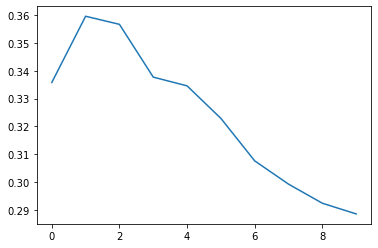

In [220]:
plt.plot(f1ScoreMeanlist)

#### Box plot F Score

In [267]:
n = 50
f1ScoreMeanlist = []
results = pd.DataFrame(columns=['n', 'index', 'fScore'])
for i in range(n):
    ignoreList = ["AlCU91", "AlCU98-8H" ]
    fscoreList = []
    precisionResult=[]
    recallResult=[]
    tmp_results = pd.DataFrame()
    

    for outerIndex in range(len(dictionaryList)):
        TruePositive = 0
        FalsePositive = 0
        FalseNegative = 0

        Precision = 0
        Recall = 0
        F1Score = 0

        tempDictionary = dictionaryList[outerIndex]
        fileNamesTemp = fileNameList[outerIndex].replace('.xlsx','').split('_')[1:]
        falseList = dict.fromkeys(set(fileNamesTemp), True)
        for innerIndex in range(len(tempDictionary)):
            tempBoolState = False
            mineralNameTemp = tempDictionary[innerIndex][0].split(' ')[0]
            for fileName in fileNamesTemp:
                if mineralNameTemp in fileName:
                    #print(fileName)
                    falseList[mineralNameTemp] = False
                    TruePositive = TruePositive + 1
                    tempBoolState = True
            if tempBoolState == False:
                FalsePositive = FalsePositive + 1
            if (innerIndex + 1 == i+1):
                FalseNegative = sum(falseList.values())
                Precision = TruePositive / (TruePositive + FalsePositive)
                Recall = TruePositive / (TruePositive + FalseNegative)
                if Precision != 0 or Recall != 0:
                    F1Score = 2 * (Precision * Recall) / (Precision + Recall)
                else:
                    F1Score = 0
                precisionResult.append(Precision)
                recallResult.append(Recall)
                fscoreList.append(F1Score)
                break
    tmp_results['n'] = [i+1]*len(fscoreList)
    tmp_results['index'] = range(len(fscoreList))
    tmp_results['fScore'] = fscoreList
    tmp_results['recall'] = recallResult
    tmp_results['precision'] = precisionResult
    results = results.append(tmp_results)

In [480]:
results

,n,index,fScore,recall,precision
0,1,0,0.000000,0.000000,0.00
1,1,1,0.000000,0.000000,0.00
2,1,2,0.000000,0.000000,0.00
3,1,3,0.666667,0.500000,1.00
4,1,4,0.000000,0.000000,0.00
...,...,...,...,...,...
145,50,145,0.142857,0.666667,0.08
146,50,146,0.000000,0.000000,0.00
147,50,147,0.333333,1.000000,0.20
148,50,148,0.181818,1.000000,0.10


In [481]:
DataFrame_SFF

,n,index,fScore,recall,precision
0,1,0,0.000000,0.000000,0.0
1,1,1,0.666667,0.500000,1.0
2,1,2,0.000000,0.000000,0.0
3,1,3,0.000000,0.000000,0.0
4,1,4,0.000000,0.000000,0.0
...,...,...,...,...,...
145,1,145,0.500000,0.333333,1.0
146,1,146,0.000000,0.000000,0.0
147,1,147,0.500000,0.333333,1.0
148,1,148,0.666667,0.500000,1.0


<AxesSubplot:xlabel='n', ylabel='fScore'>

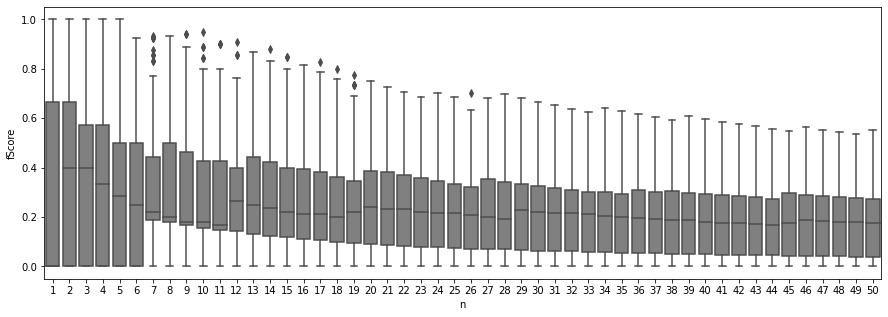

In [275]:
fig = plt.figure(figsize=(15, 5))
sns.boxplot(data=results, x='n', y='fScore', color='gray')

<AxesSubplot:xlabel='n', ylabel='precision'>

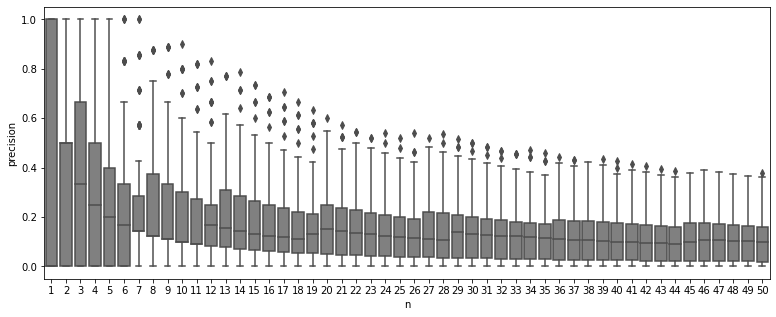

In [270]:
fig = plt.figure(figsize=(13, 5))
sns.boxplot(data=results, x='n', y='precision', color='gray')

<AxesSubplot:xlabel='n', ylabel='recall'>

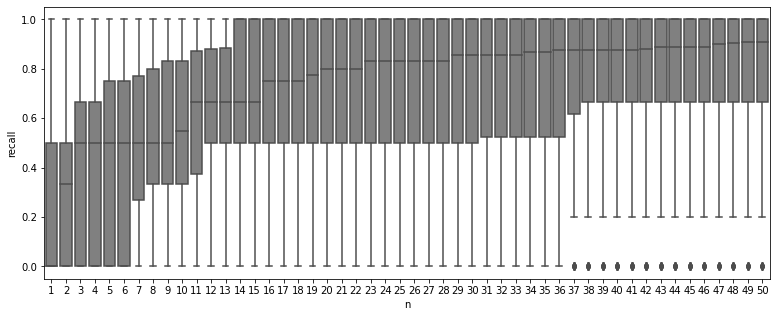

In [271]:
fig = plt.figure(figsize=(13, 5))
sns.boxplot(data=results, x='n', y='recall', color='gray')

In [274]:
results

,n,index,fScore,recall,precision
0,1,0,0.000000,0.000000,0.00
1,1,1,0.000000,0.000000,0.00
2,1,2,0.000000,0.000000,0.00
3,1,3,0.666667,0.500000,1.00
4,1,4,0.000000,0.000000,0.00
...,...,...,...,...,...
145,50,145,0.142857,0.666667,0.08
146,50,146,0.000000,0.000000,0.00
147,50,147,0.333333,1.000000,0.20
148,50,148,0.181818,1.000000,0.10


### Area Under The Curve

In [299]:
n = 100
f1ScoreMeanlist = []
resultsAUC = pd.DataFrame(columns=['index', 'AUCScore'])

steps = 1/n
AUCScore = []
#ignoreList = ["AlCU91", "AlCU98-8H" ]
fscoreList = []
precisionResult=[]
recallResult=[]
X = [0]
Y = [0]



for outerIndex in range(len(dictionaryList)):
    X = [0]
    Y = [0]
    tempDictionary = dictionaryList[outerIndex]
    fileNamesTemp = fileNameList[outerIndex].replace('.xlsx','').split('_')[1:]
    falseList = dict.fromkeys(set(fileNamesTemp), True)
    for innerIndex in range(len(tempDictionary)):
        tempBoolState = False
        mineralNameTemp = tempDictionary[innerIndex][0].split(' ')[0]
        for fileName in fileNamesTemp:
            if mineralNameTemp in fileName:

                tempBoolState = True
                Y.append(Y[len(Y)-1] + steps)
                
        if tempBoolState == False:
            Y.append(Y[len(Y)-1])
            
        X.append(X[len(X)-1] + steps)
        if (innerIndex + 1 == n):
            AUCScore.append(auc(X,Y))
            break
resultsAUC['index'] = range(len(AUCScore))
resultsAUC['AUCScore'] = AUCScore

In [311]:
scores = [1, 2, 4, 5, 1.3, 3, 7, 8, 2.5, 3.3]
matches = [False, False, False, False, True, False, False, False, False, True]

index       1.0000
AUCScore    0.0672
Name: 1, dtype: float64

In [ ]:
tpr, fpr, AUC = ROC(scores, matches, False)
AUC

In [ ]:
fig = plt.figure(figsize=(5,5))
plt.plot(fpr, tpr)
plt.plot([0,1], [0,1], '--r')